아래 내용은 Ethan Rosenthal의 블로그의 내용과 소스코드를 바탕으로 번역 및 일부 수정한 내용입니다.

원본을 보시고 싶으신 분은 아래 사이트를 방문해주세요

- 블로그: http://blog.ethanrosenthal.com/
- github: https://github.com/EthanRosenthal/DataPiques_source

앞서 Matrix Factorization 기법을 살펴보았고 ALS, SGD 알고리즘으로 학습하는 방법을 구현했다. 근데 코드가 최적화가 되지 않아 속도가 매우 
느렸다. 그래서, 이미 구현되어 사람들이 사용하고 있는 패키지를 통해 학습을 시켜보도록 하겠다.

### 데이터셋

학습에 사용할 데이터는 블로그 저자가 직접 [Sketchfab](https://sketchfab.com/) 사이트에서 수집한 implicit feedback이다. 
데이터의 구성은 user의 id와 user가 클릭한 모델의 id, 정보로 구성된다. 이 정보를 정리해서 특정 user가 모델을 클릭했는지 유무(0, 1)를 나타내는 user_item matrix를 만들어 사용한다.

### 사용 모델 

[Collaborative Filtering for Implicit Feedback Datasets](http://yifanhu.net/PUB/cf.pdf) 논문의 모델을 사용한다. 이전에 다뤘던 ALS와 거의 비슷한 내용인데 기존에 explicit feedback에 사용했지만 implicit feedback에 사용하면서 약간 수식적으로 변하는 부분이 있다. 저자가 해당 모델을 Weighted Regularized Matrix Factorization(WRMF)라고 부르므로 이 명칭으로 부르도록 하겠다.

### 목적 함수 

이전 [post](https://github.com/whikwon/recommender-system/blob/master/code/2016-01-09-explicit-matrix-factorization-als-sgd.ipynb)에서 explicit feedback에 사용한 목적 함수를 그대로 가져오자. (bias는 뺀다.) 

$$L_{exp} = \sum\limits_{u,i \in S}(r_{ui} - \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i})^{2} + \lambda_{x} \sum\limits_{u} \left\Vert \textbf{x}_{u} \right\Vert^{2} + \lambda_{y} \sum\limits_{u} \left\Vert \textbf{y}_{i} \right\Vert^{2}$$

각 항들에 대해 정리하고 넘어가면 $r_{ui}$는 user의 item에 대한 평점, $\textbf{x}_{u}$는 latent factor로 이루어진 u번째 user의 vector, $\textbf{y}_i$는 i번째 item의 vector이다. 그리고 $\lambda$ 항은 regularization term이다.

잘 생각해보면 $r_{ui}$이 user의 item에 대한 평점인데 implicit feedback에는 그런 정보가 없다. 우리가 정보를 보고 어느 정도 유추할 수 있을 뿐이지 explicit과 같이 명시적으로 나타내지 않고 있다. 그래서 $r_{ui}$에 대한 항을 조금 변경해주어야 한다. 

방법은, preference항(${p}_{ui}$)과 confidence항($c_{ui}$)으로 쪼개서 다루는 것이다. user가 해당 item과 상호작용이 있었다면 $p_{ui} = 1$ 값으로, 그렇지 않다면 $p_{ui} = 0$으로 지정한다. item이 user에게 알려지지 않았을 수도 있고 운이 없어서 그럴 수도 있지만 
일단 우리는 ***상호작용한 item에 user는 어느 정도 선호도가 있다고 생각한다는 것이다.*** 

$c_{ui}$항은 신뢰도를 나타낸다. implicit한 정보를 봤을 때 user의 개별 행동에 대해서(*예를 들면 상품 클릭*) 이 행동이 관심이 있어서 한 건지 아니면 잘못 눌러서 한 건지 알 길이 없다. 그래서, 더 많이 클릭하거나 오래 머무르거나 구매한 item에 대해서 ***신뢰도가 높은 정보라고 생각한다.*** 이를 식으로 나타내면 아래와 같고 $\alpha$는 hyperparameter, $d_{ui}$는 클릭 횟수, 머무른 시간 등의 정보를 나타낸다.

$$c_{ui} = 1 + \alpha d_{ui}$$

위에서 소개한 $p_{ui}, c_{ui}$항을 기존 식에 넣어 아래와 같은 새로운 목적 함수를 구할 수 있게 된다. ***user가 선호하는 item을 맞추는 것이 목표이며 이 때, 얼마나 관심을 가졌는지(신뢰도)가 고려되어 관심을 가진 item에 더 가중치가 생겨 학습되게 된다.*** 앞서 마찬가지로 $L$을 최소화 시켰을 때 우리가 원하는 $\textbf{x}_{u}$, $\textbf{y}_{i}$을 구할 수 있다.

$$L_{WRMF} = \sum\limits_{u,i}c_{ui} \big( p_{ui} - \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i} \big) ^{2} + \lambda_{x} \sum\limits_{u} \left\Vert \textbf{x}_{u} \right\Vert^{2} + \lambda_{y} \sum\limits_{u} \left\Vert \textbf{y}_{i} \right\Vert^{2}$$

학습 방법은 이전 post에서 소개했으므로 생략하도록 하고 새로운 항으로 인해서 update해야 할 식이 조금 바뀌었는데 이는 StackOverflow [답변](https://math.stackexchange.com/questions/1072451/analytic-solution-for-matrix-factorization-using-alternating-least-squares/1073170#1073170)이나 Sudeep Das의 [post](http://datamusing.info/blog/2015/01/07/implicit-feedback-and-collaborative-filtering/) 를 참고하자. 


### 라이브러리 

수식이 이해를 위해선 Chris Johnson의 [repo](https://github.com/MrChrisJohnson/implicit-mf/blob/master/mf.py)에 간단하게 잘 구현되어 있으므로 참고하자. 이 외에 실제로 사용할 라이브러리는 [implicit](https://github.com/benfred/implicit)이다. python에서 ALS를 지원하는 라이브러리가 몇 개 없긴 하지만 그 중에서 가장 빠르다고 한다. 

implicit 라이브러리에서 저자가 필요(learning curve, $\alpha$)에 의해 몇 가지 추가한 코드가 있어서 이를 반영해서 [gist](https://gist.github.com/whikwon/7dda3e008cf1f407d449f0045caa56b0)에 올려놓았다. `pip install implicit`로 라이브러리를 설치한 뒤 als.py 부분을 수정하면 된다.

## 데이터 전처리

데이터를 불러오면 `modelname`, `mid`, `uid`의 정보를 가진 3개 column으로 이루어져 있다. 이를 user_item 형식의 matrix로 만들어주고 
user가 관심을 보인 item에는 1, 외에는 0을 채워주자.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import pickle
import csv
import implicit
import itertools
import copy
plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2

In [2]:
# 데이터를 불러온다. 
df = pd.read_csv('../dataset/model_likes_anon.psv',
                 sep='|', quoting=csv.QUOTE_MINIMAL,
                 quotechar='\\')
df.head()
# 중복된 데이터를 제거한다. (count로 0,1을 만들어주기 위함.)
df.drop_duplicates(inplace=True)

In [3]:
df = df[['uid', 'mid']]
df.head()

,uid,mid
0,7ac1b40648fff523d7220a5d07b04d9b,5dcebcfaedbd4e7b8a27bd1ae55f1ac3
1,2b4ad286afe3369d39f1bb7aa2528bc7,5dcebcfaedbd4e7b8a27bd1ae55f1ac3
2,1bf0993ebab175a896ac8003bed91b4b,5dcebcfaedbd4e7b8a27bd1ae55f1ac3
3,6484211de8b9a023a7d9ab1641d22e7c,5dcebcfaedbd4e7b8a27bd1ae55f1ac3
4,1109ee298494fbd192e27878432c718a,5dcebcfaedbd4e7b8a27bd1ae55f1ac3


In [4]:
# sparsity가 어느 정도인지 확인해보자. 
n_users = df.uid.unique().shape[0]
n_items = df.mid.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of models: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(df.shape[0]) / float(n_users*n_items) * 100))

Number of users: 62583
Number of models: 28806
Sparsity: 0.035%


sparse한 데이터를 dense하게 만들기 위해서 일정 수 이상 like를 좋아한 user만 남겨준다. implicit feedback의 경우 좀 더 dense할 때 도움이 되는 경우가 있다고 한다. (*원래 explicit보다 implicit이 dense하긴 하다.*)

그래서 5개 이상 관심을 보인 user, 5개 이상 관심을 받은 item만 남기고 다 제외한다. n개로 바꿔서 해보면서 성능을 비교해봐도 좋겠다.

In [5]:
def threshold_likes(df, uid_min, mid_min):
    n_users = df.uid.unique().shape[0]
    n_items = df.mid.unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_users*n_items) * 100
    print('Starting likes info')
    print('Number of users: {}'.format(n_users))
    print('Number of models: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done = False
    while not done:
        starting_shape = df.shape[0]
        mid_counts = df.groupby('uid').mid.count()
        df = df[~df.uid.isin(mid_counts[mid_counts < mid_min].index.tolist())]
        uid_counts = df.groupby('mid').uid.count()
        df = df[~df.mid.isin(uid_counts[uid_counts < uid_min].index.tolist())]
        ending_shape = df.shape[0]
        if starting_shape == ending_shape:
            done = True
    
    assert(df.groupby('uid').mid.count().min() >= mid_min)
    assert(df.groupby('mid').uid.count().min() >= uid_min)
    
    n_users = df.uid.unique().shape[0]
    n_items = df.mid.unique().shape[0]
    
    # sparsity: 전체 데이터 개수 / user수 * item수 
    sparsity = float(df.shape[0]) / float(n_users*n_items) * 100
    print('Ending likes info')
    print('Number of users: {}'.format(n_users))
    print('Number of models: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [6]:
df_lim = threshold_likes(df, 5, 5)

Starting likes info
Number of users: 62583
Number of models: 28806
Sparsity: 0.035%
Ending likes info
Number of users: 15274
Number of models: 25655
Sparsity: 0.140%


데이터가 조금 dense하게 변한 것을 확인할 수 있다.(0.035% -> 0.140%) 이제 sparse matrix로 변경하기 전에 user id, model id 정보를 dictionary로 저장해놓도록 하자. (나중에 최종적으로 평가할 때 쓴다.)

In [7]:
# Create mappings
mid_to_idx = {}
idx_to_mid = {}
for (idx, mid) in enumerate(df_lim.mid.unique().tolist()):
    mid_to_idx[mid] = idx
    idx_to_mid[idx] = mid
    
uid_to_idx = {}
idx_to_uid = {}
for (idx, uid) in enumerate(df_lim.uid.unique().tolist()):
    uid_to_idx[uid] = idx
    idx_to_uid[idx] = uid

기존 matrix 형태로 사용하게 되면 memory를 너무 많이 사용하고 속도도 느리다. <br>
그래서 이를 sparse matrix로 만들어준다. sparse matrix는 값이 있는 부분에 대해서만 행, 열 정보를 저장해서 사용하므로 효율적이다. 
sparse matrix에 관한 정보는 scipy [documentation](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.coo_matrix.html)와 [wikipedia](https://en.wikipedia.org/wiki/Sparse_matrix)를 참고하자.

In [10]:
I = df_lim.uid.apply(lambda x: uid_to_idx[x]).as_matrix()
J = df_lim.mid.apply(lambda x: mid_to_idx[x]).as_matrix()
V = np.ones(I.shape[0])
likes = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
likes = likes.tocsr()

## Cross-validation: Train-test split

이제 우리가 원하는 sparse matrix 형태의 데이터를 얻었다. 전체 데이터를 train과 test 데이터로 나누어 검증에 사용할 것이다.
데이터를 뽑는 방법은 뒤에서 평가할 precision@k를 고려하여 2*k개 이상 관심를 보인 user로부터 k개의 데이터를 뽑아서 test 데이터로 지정해주고 같은 부분의 train 데이터는 0의 값을 넣어준다. 

앞서 5개 이상의 관심를 보인 user만 남겼는데 여기에서 한 번더 거르게 되므로 데이터가 전체적으로 관심이 많은 user 쪽으로 편향되게 된다. 

In [13]:
def train_test_split(ratings, split_count, fraction=None):
    """
    Split recommendation data into train and test sets
    
    Params
    ------
    ratings : scipy.sparse matrix
        Interactions between users and items.
    split_count : int
        Number of user-item-interactions per user to move
        from training to test set.
    fractions : float
        Fraction of users to split off some of their
        interactions into test set. If None, then all 
        users are considered.
    """
    train = ratings.copy().tocoo()
    test = sparse.lil_matrix(train.shape)
    
    if fraction:
        try:
            # np.bincount: 있는 값들이 indices라고 생각하고 개수를 세서 indices에 반환해준다.  
            # user 별로 10개 이상 평가했는지 확인한 다음에 한 user들 대상으로 무작위로 indices를 뽑는다. 
            user_index = np.random.choice(
                np.where(np.bincount(train.row) >= split_count * 2)[0], 
                replace=False,
                size=np.int32(np.floor(fraction * train.shape[0]))
            ).tolist()
        except:
            print(('Not enough users with > {} '
                  'interactions for fraction of {}')\
                  .format(2*k, fraction))
            raise
    else:
        user_index = range(train.shape[0])
        
    # 행, 열 정보를 가져오기(subscriptable) 위해서는 lil 형식으로 바꿔줘야 한다. 
    train = train.tolil()
    
    for user in user_index:
        # 위에서 고른 user에 대해서 indices(model) 들을 보고 그 중에 무작위로 5개를 뽑는다. 
        test_ratings = np.random.choice(ratings.getrow(user).indices, 
                                        size=split_count, 
                                        replace=False)
        # train에서 뽑은 indices에 대해서는 0의 값을 지정해준다. 
        train[user, test_ratings] = 0.
        # test는 반대로 위에서 뽑은 indices에 대해서 1의 값을 지정해준다. 
        test[user, test_ratings] = ratings[user, test_ratings]
   
    
    # train, test 데이터는 서로 겹치는 1의 값이 없어야 한다. 즉 곱했을 때 전부다 0이다. 
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_index

## Cross-validation: Grid search

Grid search를 이용해서 hyperparameter를 최적화시켜야 한다. hyperparameter의 종류는 아래와 같다.

1. ```factors```: latent factor 수, user, item을 나타내는 vector의 차원이다. 
2. ```regularization```: user, item factor에 대한 regularization 크기. 
3. ```alpha```: confidence 크기를 조절하는 값. 
4. ```iterations```: ALS 학습 iteration 수.

mean squared error (MSE)와 precision at k (p@k) 방법을 통해서 평가를 진행하고 hyperparameter 별로 learning curve를 그려서 
비교하도록 하자.

In [14]:
train, test, user_index = train_test_split(likes, 5, fraction=0.2)

In [16]:
# MSE를 구현했다. 
# 전체 user 대상으로 하거나 특정 user_index에 대해서만 평가할 수 있다. 
from sklearn.metrics import mean_squared_error

def calculate_mse(model, ratings, user_index=None):
    # user에 대한 item 선호도 전체를 구한다. 
    preds = model.predict_for_customers()
    if user_index:
        return mean_squared_error(ratings[user_index, :].toarray().ravel(),
                                  preds[user_index, :].ravel())
    
    return mean_squared_error(ratings.toarray().ravel(),
                              preds.ravel())

In [17]:
# precision을 구하는 방식이다. k개를 고르고 그 중에 몇개나 맞는지 확인한다. 
# 전체 user 대상으로 하거나 특정 user_index에 대해서만 평가할 수 있다. 
def precision_at_k(model, ratings, k=5, user_index=None):
    if not user_index:
        user_index = range(ratings.shape[0])
    ratings = ratings.tocsr()
    precisions = []
    predictions = model.predict_for_customers()
    for user in user_index:
        top_k = np.argsort(-predictions[user, :])[:k]
        labels = ratings.getrow(user).indices
        precision = float(len(set(top_k) & set(labels))) / float(k)
        precisions.append(precision)
    return np.mean(precisions)

In [18]:
# 학습할 때 log 출력을 위한 코드
def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, float):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)

In [19]:
# learning curve를 그려주는 코드
def learning_curve(model, train, test, epochs, k=5, user_index=None):
    if not user_index:
        user_index = range(train.shape[0])
    prev_epoch = 0
    train_precision = []
    train_mse = []
    test_precision = []
    test_mse = []
    
    headers = ['epochs', 'p@k train', 'p@k test',
               'mse train', 'mse test']
    print_log(headers, header=True)
    
    for epoch in epochs:
        model.iterations = epoch - prev_epoch
        if not hasattr(model, 'user_vectors'):
            # item_to_user 형식을 받는 걸로 바뀌었다. 
            model.fit(train.T.tocsr())
        else:
            model.fit_partial(train.T.tocsr())
        train_mse.append(calculate_mse(model, train, user_index))
        train_precision.append(precision_at_k(model, train, k, user_index))
        test_mse.append(calculate_mse(model, test, user_index))
        test_precision.append(precision_at_k(model, test, k, user_index))
        row = [epoch, train_precision[-1], test_precision[-1],
               train_mse[-1], test_mse[-1]]
        print_log(row)
        prev_epoch = epoch
    return model, train_precision, train_mse, test_precision, test_mse

In [21]:
def grid_search_learning_curve(base_model, train, test, param_grid,
                               user_index=None, patk=5, epochs=range(2, 10, 2)):
    """
    "sklearn gridsearch 코드를 참고했다고 한다.
    https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py
    """
    curves = []
    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        this_model = copy.deepcopy(base_model)
        print_line = []
        for k, v in params.items():
            setattr(this_model, k, v)
            print_line.append((k, v))

        print(' | '.join('{}: {}'.format(k, v) for (k, v) in print_line))
        _, train_patk, train_mse, test_patk, test_mse = learning_curve(this_model, train, test,
                                                                epochs, k=patk, user_index=user_index)
        curves.append({'params': params,
                       'patk': {'train': train_patk, 'test': test_patk},
                       'mse': {'train': train_mse, 'test': test_mse}})
    return curvesd

grid를 너무 많이 넣어서 연산하면 너무 오래 걸리므로 적당히 돌려보자. 괜찮은 값은 아래에 test 결과로 있으므로 시간을 절약하기 위해서는 grid search 과정을 넘어가도 된다. 

In [22]:
param_grid = {'factors': [40], # 80, 120],
              'regularization': [0.0, 1e-5, 1e-3], # 1e-1, 1e1, 1e2]
              'alpha': [1, 10, 50]} #, 100, 500, 1000]}

In [23]:
base_model = implicit.als.AlternatingLeastSquares()

In [24]:
curves = grid_search_learning_curve(base_model, train, test,
                                    param_grid,
                                    user_index=user_index,
                                    patk=5)

factors: 40 | regularization: 0.0 | alpha: 1
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+
|     2      |  0.28762   |  0.02534   |  0.00159   |  0.00053   |
+------------+------------+------------+------------+------------+
|     4      |  0.30000   |  0.03471   |  0.00155   |  0.00058   |
+------------+------------+------------+------------+------------+
|     6      |  0.29096   |  0.03563   |  0.00154   |  0.00059   |
+------------+------------+------------+------------+------------+
|     8      |  0.28684   |  0.03615   |  0.00154   |  0.00059   |
+------------+------------+------------+------------+------------+
factors: 40 | regularization: 0.0 | alpha: 10
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+===========

아래 표는 저자가 grid search 했을 때 가장 좋았던 hyperparameter 및 결과라고 한다. 

best run:

```
alpha: 50 | num_factors: 40 | regularization: 0.1
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+
|     2      |  0.33988   |  0.02541   |  0.01333   |  0.01403   |
+------------+------------+------------+------------+------------+
|     4      |  0.31395   |  0.03916   |  0.01296   |  0.01377   |
+------------+------------+------------+------------+------------+
|     6      |  0.30085   |  0.04231   |  0.01288   |  0.01372   |
+------------+------------+------------+------------+------------+
|     8      |  0.29175   |  0.04231   |  0.01285   |  0.01370   |
+------------+------------+------------+------------+------------+
|     10     |  0.28638   |  0.04407   |  0.01284   |  0.01370   |
+------------+------------+------------+------------+------------+
|     12     |  0.28684   |  0.04492   |  0.01284   |  0.01371   |
+------------+------------+------------+------------+------------+
|     14     |  0.28533   |  0.04571   |  0.01285   |  0.01371   |
+------------+------------+------------+------------+------------+
|     16     |  0.28389   |  0.04689   |  0.01285   |  0.01372   |
+------------+------------+------------+------------+------------+
|     18     |  0.28454   |  0.04695   |  0.01286   |  0.01373   |
+------------+------------+------------+------------+------------+
|     20     |  0.28454   |  0.04728   |  0.01287   |  0.01374   |
+------------+------------+------------+------------+------------+
|     22     |  0.28409   |  0.04761   |  0.01288   |  0.01376   |
+------------+------------+------------+------------+------------+
|     24     |  0.28251   |  0.04689   |  0.01289   |  0.01377   |
+------------+------------+------------+------------+------------+
|     26     |  0.28186   |  0.04656   |  0.01290   |  0.01378   |
+------------+------------+------------+------------+------------+
|     28     |  0.28199   |  0.04676   |  0.01291   |  0.01379   |
+------------+------------+------------+------------+------------+
|     30     |  0.28127   |  0.04669   |  0.01292   |  0.01380   |
+------------+------------+------------+------------+------------+
|     32     |  0.28173   |  0.04650   |  0.01292   |  0.01381   |
+------------+------------+------------+------------+------------+
|     34     |  0.28153   |  0.04650   |  0.01293   |  0.01382   |
+------------+------------+------------+------------+------------+
|     36     |  0.28166   |  0.04604   |  0.01294   |  0.01382   |
+------------+------------+------------+------------+------------+
|     38     |  0.28153   |  0.04637   |  0.01295   |  0.01383   |
+------------+------------+------------+------------+------------+
```

learning curve를 살펴보자.

In [25]:
best_curves = sorted(curves, key=lambda x: max(x['patk']['test']), reverse=True)

In [26]:
print(best_curves[0]['params'])
max_score = max(best_curves[0]['patk']['test'])
print(max_score)
iterations = range(2, 40, 2)[best_curves[0]['patk']['test'].index(max_score)]
print('Epoch: {}'.format(iterations))

{'factors': 40, 'regularization': 0.001, 'alpha': 50}
0.0489194499018
Epoch: 8


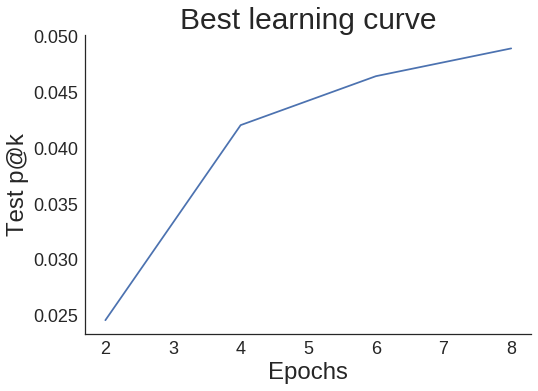

In [27]:
import seaborn as sns
sns.set_style('white')
fig, ax = plt.subplots()
sns.despine(fig);
epochs = range(2, 10, 2)
plt.plot(epochs, best_curves[0]['patk']['test']);
plt.xlabel('Epochs', fontsize=24);
plt.ylabel('Test p@k', fontsize=24);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title('Best learning curve', fontsize=30);

학습 시간이 늘어날 수록 p@k가 줄어드는 것을 볼 수 있다. 컴퓨터가 더 좋다면 좀 더 길게 학습시켜보시길 바란다. 

아래에는 hyperparameter에 따라 p@k가 어떻게 변하는 지를 보기 위해 지금까지 학습한 결과를 하나의 그래프로 나타내도록 하자.

In [30]:
all_test_patks = [x['patk']['test'] for x in best_curves]

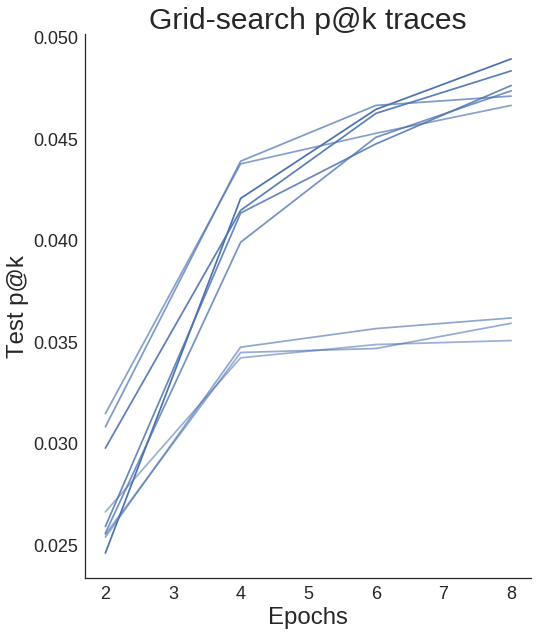

In [31]:
fig, ax = plt.subplots(figsize=(8, 10));
sns.despine(fig);
epochs = range(2, 10, 2)
totes = len(all_test_patks)
for i, test_patk in enumerate(all_test_patks):
    ax.plot(epochs, test_patk,
             alpha=1/(.1*i+1),
             c=sns.color_palette()[0]);
    
plt.xlabel('Epochs', fontsize=24);
plt.ylabel('Test p@k', fontsize=24);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title('Grid-search p@k traces', fontsize=30);

## Rec-a-sketch

위 과정을 통해서 최적의 모델, hyperparameter를 찾았으니 이 조건대로 학습하면 된다. 이제 마지막으로 우리 모델이 얼마나 추천을 잘 하는지 살펴보자. 방법은 item을 선정하고 가장 유사한 item을 추천해주는 방식이다.

In [32]:
params = best_curves[0]['params']
params['iterations'] = range(2, 40, 2)[best_curves[0]['patk']['test'].index(max_score)]
bestALS = implicit.als.AlternatingLeastSquares(**params)

In [33]:
# 전체 데이터에 대해 학습을 시키자. 
bestALS.fit(likes.T.tocsr())

```AlternatingLeastSquares``` 클래스의 ```predict_for_items``` 매서드를 사용해서 item을 입력했을 때 추천 item을 확인할 수 있으며 cosine similiarity를 사용한다. 
```python
    def predict_for_items(self, norm=True):
        """Recommend products for all products"""
        pred = self.item_vectors.dot(self.item_vectors.T)
        if norm:
            norms = np.array([np.sqrt(np.diagonal(pred))])
            pred = pred / norms / norms.T
        return pred
```

이제, sketchfab API를 이용해서 우리가 평가하려는 item과 추천해주는 k개 item의 썸네일을 받아서 보여주고 정성적으로 추천시스템이 잘 작동하는 지 확인해보자.

In [35]:
# 학습시킨 모델, item의 idx, 추천할 item 수를 입력하면 image의 url을 반환해준다. 
import requests
def get_thumbnails(model, idx, idx_to_mid, N=10):
    pred_for_item = model.predict_for_item(idx, False)
    thumbs = []
    for x in np.argsort(-pred_for_item)[:N]:
        response = requests.get('https://sketchfab.com/i/models/{}'.format(idx_to_mid[x])).json()
        thumb = [x['url'] for x in response['thumbnails']['images'] if x['width'] in [200, 256] 
                 and x['height'] in [200, 144]]
        if not thumb:
            print('no thumbnail')
        else:
            thumbs.append(thumb[0])
    return thumbs

In [36]:
# Jupyter notebook 내에 image 출력을 해주기 위해서 사용한 코드이다. 
from IPython.display import display, HTML

def display_thumbs(thumbs, N=5):
    thumb_html = "<img style='width: 160px; margin: 0px; \
                  float: left; border: 1px solid black;' src='{}' />"
    images = ''
    display(HTML('<font size=5>'+'Input Model'+'</font>'))
    display(HTML(thumb_html.format(thumbs[0])))
    display(HTML('<font size=5>'+'Similar Models'+'</font>'))

    for url in thumbs[1:N+1]:
        images += thumb_html.format(url)
    display(HTML(images))

In [38]:
# item을 무작위로 뽑아서 실행해보자.
rand_model = np.random.randint(0, len(idx_to_mid))
display_thumbs(get_thumbnails(bestALS, rand_model, idx_to_mid))

In [44]:
# item을 무작위로 뽑아서 실행해보자.
rand_model = np.random.randint(0, len(idx_to_mid))
display_thumbs(get_thumbnails(bestALS, rand_model, idx_to_mid))

In [41]:
# item을 무작위로 뽑아서 실행해보자.
rand_model = np.random.randint(0, len(idx_to_mid))
display_thumbs(get_thumbnails(bestALS, rand_model, idx_to_mid))

완벽하진 않지만 그래도 어느 정도 유사도를 학습한 것으로 보인다. 단순히 사람들이 관심도를 표현한 내용만 가지고 이렇게 item 간에 유사성을 학습한 것이 신가하다. 앞으로 다른 implicit feedback을 학습시킬 다른 모델을 살펴보고 Neural Network로 학습시키는 방법을 살펴본다고 한다.